# Self-Driving Car Nanodegree

## Deep Learning

## Project: Behavior Transfer

In this project we will use behavioral cloning to teach a deep learning network to drive a simulated car using nothing but images of the road.

## Getting Started

In [1]:
# Import libraries necessary for this project.
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Activation, Conv2D, Dense, Dropout, ELU, Flatten
from keras.optimizers import Adam

from PIL import Image

from sklearn.model_selection import train_test_split

from IPython.display import display

%matplotlib inline

Using TensorFlow backend.


The first step of the project is to load the data collected from the simulator. This consisted of images taken from the left, center, and right cameras of the car at periodic intervals by the simulator.

Due to the size of the images generated by the simulator, the data is not included in the project repository. The model was trained using the provided Udacity data set, which can be downloaded from the project page and unzipped into this directory.

In [2]:
# Location of the simulator data.
DATA_FILE = 'driving_log.csv'

# Load the training data from the simulator.
cols = ['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 'Throttle', 'Break', 'Speed']
data = pd.read_csv(DATA_FILE, names=cols, header=1)

## Data Exploration

The data DataFrame contains information about the data collected from the simulator training. An investigation of this file will help us begin to understand how to create a model for behavior transfer.

In [3]:
display(data.head())

,Center Image,Left Image,Right Image,Steering Angle,Throttle,Break,Speed
0,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
1,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
2,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
3,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236
4,IMG/center_2016_12_01_13_31_13_279.jpg,IMG/left_2016_12_01_13_31_13_279.jpg,IMG/right_2016_12_01_13_31_13_279.jpg,0.0,0.0,0.0,1.403993


As shown above, the data file contains seven columns: URLs for the captured center, left, and right images; the steering angle; the throttle rate; braking; and speed. Each row captures a snapshot of what was happening in the simulator.

In [4]:
display(data.describe())

,Steering Angle,Throttle,Break,Speed
count,8035.000000,8035.000000,8035.000000,8035.000000
mean,0.004070,0.869768,0.001970,28.170589
std,0.128848,0.301188,0.036567,6.149343
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183100
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


The summary statistics above show some interesting information about the data.

* Steering angle: While the steering angle varied between -1 and 1, it was almost always at 0. The mean is slightly to the right, which suggests additional  recovery training was done to learn how to recover from the mostly left turning track.
* The throttle was almost always fully engaged, only occassionally being released to allow the vehicle to slow down.
* The break was only applied very lightly while driving.
* The car was driven almost exclusively at its full speed of 30 mph.

It will be interesting to see how successfully the model will be when trained with this high velocity driving and whether it will generalize to slower driving speeds.

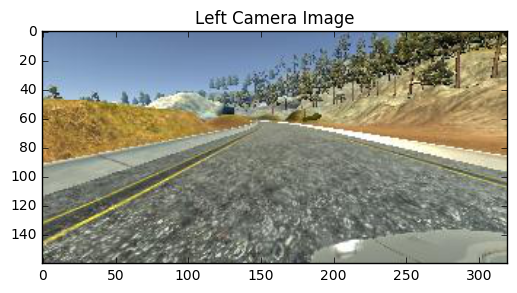

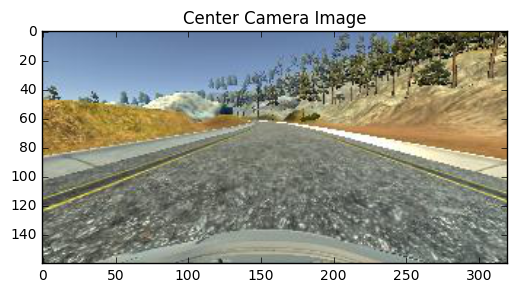

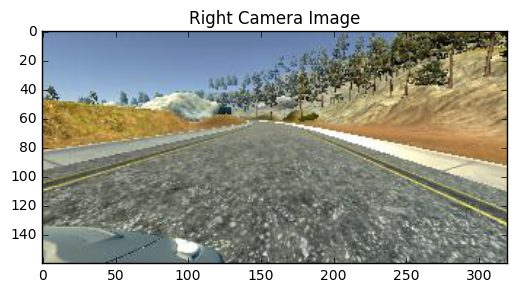

In [5]:
left_image = Image.open('left.jpg')
_ = plt.imshow(left_image)
plt.title('Left Camera Image')
plt.show()

center_image = Image.open('center.jpg')
_ = plt.imshow(center_image)
plt.title('Center Camera Image')
plt.show()

right_image = Image.open('right.jpg')
_ = plt.imshow(right_image)
plt.title('Right Camera Image')
plt.show()

Shown above are sample images from the three simulator cameras taken at the same time. While the steering angle prediction will be made from only the center camera images, the other two cameras will be used in training to augment the training data. In particular, modifying the actual steering angle for the additional images will enable us to train the model to recover if the car veers off course. In addition, this will provide a stream of data with nonzero angles to help counterbalance the predominantly zero angle samples.

## Design and Test Model

The first thing to do is to split out the data set into the features that will be trained and the corresponded steering angle that will be predicted. To limit the amount of memory consumed by the simulator images, we will leave the features as the paths to the images. The images can then be loaded on demand as needed.

In [6]:
images = data[['Center Image', 'Left Image', 'Right Image']]
angles = data['Steering Angle']

The next step is to separate the data into training and validation sets. The training set will be used to train the model while the validation set will be used to validate the progress of the training. No separate test set will be used as the performance of the model will be tested on the track.

It's particularly important to shuffle the data so that the training, validation, and test sets receive samples from all areas of the tracks.

In [7]:
images_train, images_validation, angles_train, angles_validation = train_test_split(
    images, angles, test_size=0.15, random_state=42)

Now it's time to design the keras model.

The model is based on the NVIDIA model, which has proven itself to solve the steering angle problem in the field. The model distinguishing itself from other classic models used in image recognition in that it eschews pooling layers in favor of strided convolution layers. This design choice was likely made to speed up the operation of the network to make it more useful for realtime predictions.

In the NVIDIA model, YUV images were used as input. This is a natural since since camera images are usually captured as YUV. However, the images generated by the simulator are standard RGB. Instead of converting the images, which could consume valuable time, this model uses a 1x1x3 convolution which theoretically will allow the model to learn its own colorspace translation.

A final 3x3 convolution was added that was not present in the NVIDIA paper. The simpler model was not able to fully complete the track. 
 
An ELU activation function was used after each layer to avoid sudden cutoff that a normal ReLU would have. To help reduce overfitting, a dropout layer was added after each convolution and fully connected layer.

An ADAM optimizer was chosen to train the model. A larger than default learning rate was selected to help speed up the training rate to reduce the number of iterations needed to train the model.

The final model consists of:
* 3@1x1 convolution filter with ELU activation followed by a dropout.
* 3@5x5 convolution filter with 2x2 stride and ELU activation followed by a dropout.
* 24@5x5 convolution filter with 2x2 stride and ELU activation followed by a dropout.
* 36@5x5 convolution filter with 2x2 stride and ELU activation followed by a dropout.
* 48@3x3 convolution filter with ELU activation followed by a dropout.
* 64@3x3 convolution filter with ELU activation followed by a dropout.
* 128@3x3 convolution filter with ELU activation followed by a dropout.
* 100 node fully connected layer with ELU activation followed by a dropout.
* 50 node fully connected layer with ELU activation followed by a dropout.
* 10 node fully connected layer with ELU activation followed by a dropout.
* 1 node output layer.

In [8]:
model = Sequential()
model.add(Conv2D(3, 1, 1, input_shape=(90, 320, 3)))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Conv2D(3, 5, 5, subsample=(2, 2)))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Conv2D(24, 5, 5, subsample=(2, 2)))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Conv2D(36, 5, 5, subsample=(2, 2)))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Conv2D(48, 3, 3))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Conv2D(64, 3, 3))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Conv2D(128, 3, 3))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(1))

optimizer = Adam(lr=0.001)
model.compile(loss='mse', optimizer=optimizer)

Now that the model has been defined, we can examine a summary of the model as it has been built by keras. This summary contains information about the shape of the layers and the number of trainable parameters, which will help demonstrate the complexity of the model that will be used.

In [9]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 90, 320, 3)    12          convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 90, 320, 3)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 90, 320, 3)    0           elu_1[0][0]                      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 43, 158, 3)    228         dropout_1[0][0]                  
___________________________________________________________________________________________

Now it's time to compile and train the model.

First we will define a function to load and normalize the sample images. Because the using the model will require the same preprocessing to be done, we make sure that any work is as lightweight as possible. First, the pixel values are normalized to a range between -1 and 1. Then the top and bottom of the image are removed. The removes the sky as a distraction and also the hood of the car, allowing the training to focus on the features of the road.

The image loader also has an option to flip the image before returning it. This will be useful for data augmentation.

In [10]:
def load_image(path, flip=False):
    # Read the image from disk, and flip it if requested.
    image = Image.open(path.strip())
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Normalize the image pixels to range -1 to 1.
    image = np.array(image, np.float32)
    image /= 127.5
    image -= 1.
    
    # Slice off the top and bottom pixels to remove the sky
    # and the hood of the car.
    image = image[40:130, :]
    
    # Return the normalized image.
    return image

With the image loader complete, we can now use it to build a generator that will supply images and predicted steering angles for training.

The batch generator will augment the training data with a number of different transformations. The center image can be flipped so that the model can learn about 

In [11]:
def generate_batches(images, angles, batch_size=64, augment=True):
    # Create an array of sample indexes.
    indexes = np.arange(len(images))
    batch_images = []
    batch_angles = []
    sample_index = 0
    while True:
        # Reshuffle the indexes after each pass through the samples to minimize
        # overfitting on the data.
        np.random.shuffle(indexes)
        for i in indexes:
            # Increment the number of samples. 
            sample_index += 1
            
            # Load the center image and weight.
            center_image = load_image(images.iloc[i]['Center Image'])
            center_angle = float(angles.iloc[i])
            batch_images.append(center_image)
            batch_angles.append(center_angle)
            
            # Add augmentation if requested
            if augment:
                # Load the flipped image and invert angle
                flipped_image = load_image(images.iloc[i]['Center Image'], True)
                flipped_angle = -1. * center_angle
                batch_images.append(flipped_image)
                batch_angles.append(flipped_angle)

                # Load the left image and adjust angle
                left_image = load_image(images.iloc[i]['Left Image'])
                left_angle = min(1.0, center_angle + 0.25)
                batch_images.append(left_image)
                batch_angles.append(left_angle)

                # Load the right image and adjust angle
                right_image = load_image(images.iloc[i]['Right Image'])
                right_angle = max(-1.0, center_angle - 0.25)
                batch_images.append(right_image)
                batch_angles.append(right_angle)
            
            # If we have processed batch_size samples or this is the last batch
            # of the epoch, then submit the batch. Note that due to augmentation
            # there may be more than batch_size elements in the batch.
            if (sample_index % batch_size) == 0 or (sample_index % len(images)) == 0:
                yield np.array(batch_images), np.array(batch_angles)
                batch_images = []
                batch_angles = []

Now that the data generator is defined, it's time to finally train the model. The number of samples per epoch is set to be the actual number of training samples times the number of augmented samples generated for each input.

In [12]:
nb_epoch = 25

samples_per_epoch = 4 * len(images_train)
generator_train = generate_batches(images_train, angles_train)

nb_val_samples = len(images_validation)
generator_validation = generate_batches(images_validation, angles_validation, augment=False)

history = model.fit_generator(
    generator_train, samples_per_epoch=samples_per_epoch, nb_epoch=nb_epoch,
    validation_data=generator_validation, nb_val_samples=nb_val_samples)

Epoch 1/25
27316/27316 [==============================] - 90s - loss: 0.0394 - val_loss: 0.0123
Epoch 2/25
27316/27316 [==============================] - 83s - loss: 0.0357 - val_loss: 0.0125
Epoch 3/25
27316/27316 [==============================] - 83s - loss: 0.0335 - val_loss: 0.0188
Epoch 4/25
27316/27316 [==============================] - 84s - loss: 0.0322 - val_loss: 0.0119
Epoch 5/25
27316/27316 [==============================] - 83s - loss: 0.0311 - val_loss: 0.0105
Epoch 6/25
27316/27316 [==============================] - 83s - loss: 0.0304 - val_loss: 0.0129
Epoch 7/25
27316/27316 [==============================] - 83s - loss: 0.0300 - val_loss: 0.0134
Epoch 8/25
27316/27316 [==============================] - 83s - loss: 0.0291 - val_loss: 0.0119
Epoch 9/25
27316/27316 [==============================] - 83s - loss: 0.0285 - val_loss: 0.0137
Epoch 10/25
27316/27316 [==============================] - 83s - loss: 0.0277 - val_loss: 0.0190
Epoch 11/25
27316/27316 [==============

Save the model and the trained weights so that they can be used to drive the simulator.

In [13]:
model.save_weights('model.h5', True)
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

Now that the model has been trained, we can visualize the loss of both the training and validation sets.

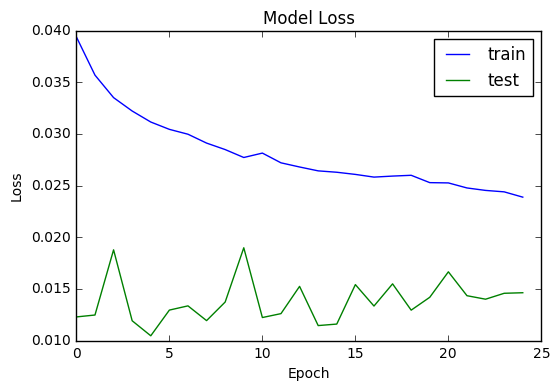

In [14]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Interpreting the results of the loss function is a bit problematic. The training loss is artificially higher because of the synthesized steering angles for the left and right camera images. The validation loss is low because most of the images are of driving straight ahead but we really need to learn how to take turns.

Experimentation with weights generated at different epoch showed that the car's performance because much smoother with more learning. The plot above, however, shows a rising validation loss which could suggest that the model might be starting to overfit the training data.

## Running the Simulation

The true test of how good the model learned is how the car performs on the simulated track. The performance of the model was very dependent on the quality level used to generate the training images and the quality level used to run the simulation. For this experiment, the simulator was run at 640x480 resolution with "fastest" quality.

Videos of the car's performance on track 1, as well as how it generalized to track 2, are available here:

* [Track 1](https://www.youtube.com/watch?v=6Mt121Qj8DI)
* [Track 2](https://www.youtube.com/watch?v=QkBzyO3vZCE&t=26s)

To complete the simulation, a few changes were mode to the provided ```drive.py``` script:

* The camera images from the simulator were preprocessed in the same way as the training data. The top and bottom portions of the image were removed, and the pixel values were scaled to a range of -1 to 1.
* The predicted steering angle returned by the model was multiplied by a small constant to allow the car to take sharper turns on some corners.
* The throttle was adjusted to to take the speed of the car into account. This was particular important on track 2 to allow the car to start from a hill and power through the inclined road.

## Observations

This project showed that it was possible to successfully train a (simulated) car using only images from a camera mounted in the car. The trained model was even able to successfully complete a challenging course on a track which it had never seen before.

Completing the project was not without its challenges. I had originally tried to replicate the results of NVIDIA's self-driving car experiments by replicating the model architecture they had use. However, I was not able to successfully complete the track with that model. Instead I ultimately needed to add an additional layer to the model. This was most likely due to insufficient data collection and augmentation.

Data augmentation proved to be key to successfully completing the project. In particular, adding in the left and right camera images gave enough non-zero angle examples that the model couldn't just predict zero with high certainty.